In [133]:
import io
from IPython.nbformat import current

with io.open('/project/3.ipynb', 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print(word_count)

2057


# Classification project of wine type and quality

## Introduction

Wine has physicochemical properties that vary according to the variety of grapes used, the environment they grew in, the fermentation and the production process. The two datasets, of red and white wine, were downloaded from the UC Irvine Machine Learning Repository website. The wines are variants of the Portuguese 'Vinho Verde' wine.

The two main tasks that will be explored in this notebook are:
- predicting whether the wine is red or white
- predicting if the wine is of low or high quality

The dataset consists on 12 features: fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol and the two dependent variables quality and wine type. Wine type will also be used as an independent feature when predicting wine quality. 

Understanding which attributes lead to better quality wine could help producers during the production process to control the physicochemical properties according to the quality they want to achieve. Taking into account that those properties are influenced by several other factors and are not the sole determinant of quality.

Source of datasets: https://archive.ics.uci.edu/ml/datasets/wine+quality

In [3]:
pip install spacy


         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.

  Using cached spacy-3.2.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.2 MB)
  Using cached catalogue-2.0.6-py3-none-any.whl (17 kB)
  Using cached blis-0.7.6-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.9 MB)
  Using cached preshed-3.0.6-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2

In [4]:
pip install xgboost


         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.

  Using cached xgboost-1.5.2-py3-none-manylinux2014_x86_64.whl (173.6 MB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install yellowbrick


         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.

  Using cached yellowbrick-1.4-py3-none-any.whl (274 kB)
  Using cached scikit_learn-1.0.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-

In [6]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(style='darkgrid')
import matplotlib.pyplot as plt

from sklearn.utils import shuffle

# Import datasets
white = pd.read_csv('/project/winequality-white.csv', delimiter=';')
red = pd.read_csv('/project/winequality-red.csv', delimiter=';')

In [7]:
# Add a column to both datasets to discern white and red wine when merging
white.insert(11, 'wine type', 'white')
red.insert(11, 'wine type', 'red')

# Merge the two datasets into one
wine = pd.concat([white, red])

# Randomise the dataset to have proportionate amount of red and white wine in the train and test sets
wine = shuffle(wine, random_state=70)
wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,wine type,quality
576,8.2,0.230,0.29,1.8,0.047,47.0,187.0,0.99330,3.13,0.50,10.2,white,6
376,6.4,0.310,0.28,1.5,0.037,12.0,119.0,0.99190,3.32,0.51,10.4,white,7
3418,7.2,0.370,0.40,11.6,0.032,34.0,214.0,0.99630,3.10,0.51,9.8,white,6
4815,6.2,0.760,0.01,3.2,0.041,18.0,120.0,0.99026,3.20,0.94,13.7,white,7
3550,7.2,0.140,0.32,1.1,0.022,48.0,116.0,0.99218,3.04,0.67,10.0,white,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,7.7,0.270,0.68,3.5,0.358,5.0,10.0,0.99720,3.25,1.08,9.9,red,7
1340,7.2,0.160,0.32,0.8,0.040,50.0,121.0,0.99220,3.27,0.33,10.0,white,6
3864,6.6,0.390,0.22,4.0,0.038,17.0,98.0,0.99018,3.25,0.53,13.0,white,7
336,8.9,0.430,0.45,1.9,0.052,6.0,16.0,0.99480,3.35,0.70,12.5,red,6


In [8]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6497 entries, 576 to 4310
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  wine type             6497 non-null   object 
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 710.6+ KB


In [9]:
# wine.isna().sum()

# Exploratory Data Analysis

In [10]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [11]:
# Quality score is between 0 and 10, check which scores have been attributed to the wines in our dataset:
print("White wine's quality has been labelled as", np.sort(wine['quality'].unique()))
print("Red wine's quality has been labelled as", np.sort(red['quality'].unique()))

White wine's quality has been labelled as [3 4 5 6 7 8 9]
Red wine's quality has been labelled as [3 4 5 6 7 8]


In [12]:
# Check the sum of wines for each scores
wine['quality'].value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

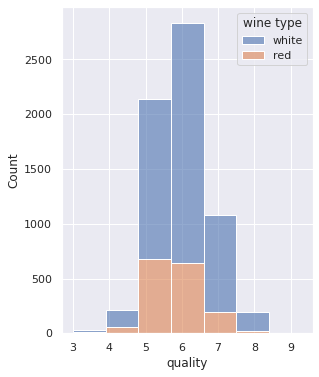

In [13]:
# Plot distribution of quality according to type of wine
plt.figure(figsize=(4.5, 6))
sns.histplot(data=wine, x='quality', hue='wine type', binwidth=0.9, alpha=0.6, multiple='stack');

In [14]:
# Function to plot violinplots for each feature and the different qualities
def violin_plot(feature, hue):
    plt.figsize=(9, 5)
    sns.violinplot(data=wine, x='quality', y=feature, hue='wine type', split=True);    
    plt.title(f'{feature.name} violin plot')
    plt.show()

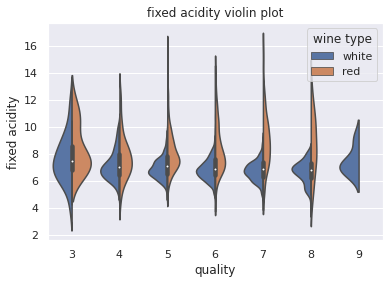

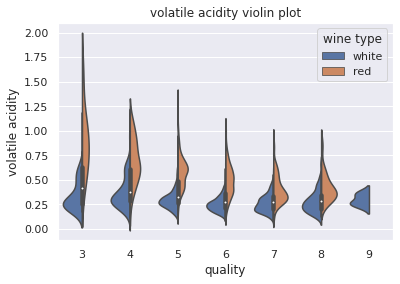

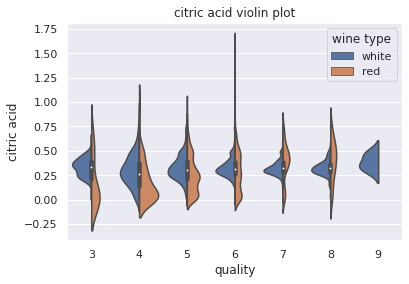

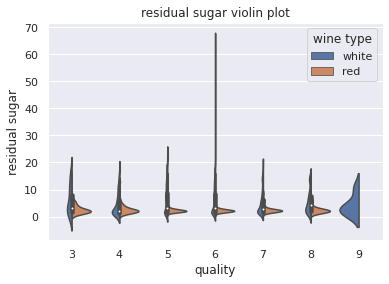

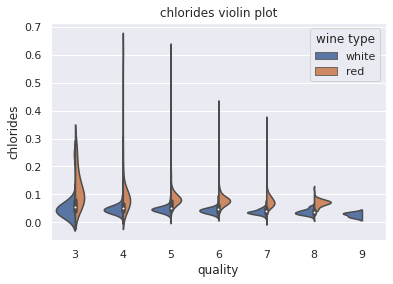

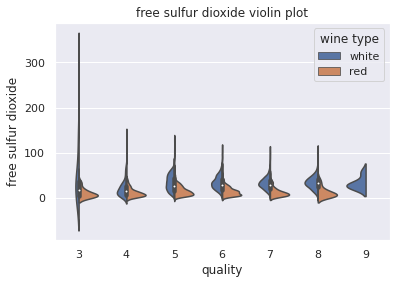

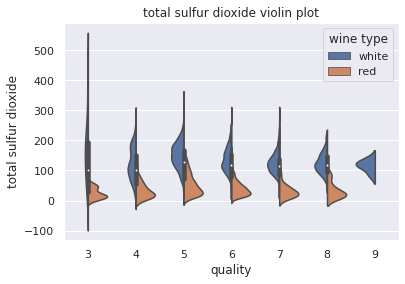

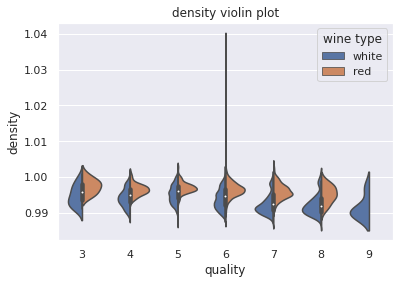

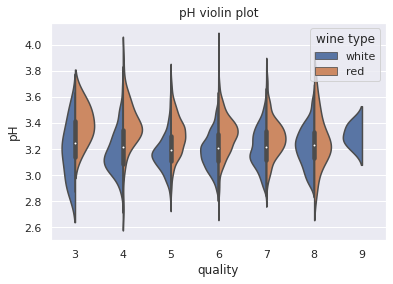

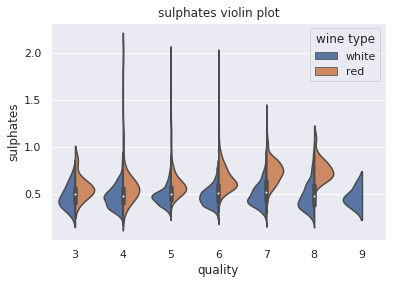

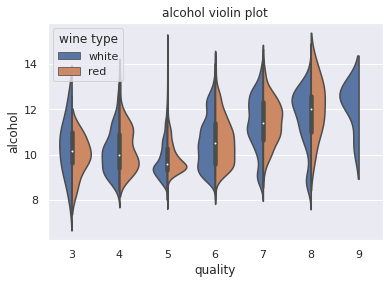

In [15]:
wine_plot = wine.iloc[:,0:-2]

for i in wine_plot.columns:
    violin_plot(wine_plot[i], wine['wine type'])

The summary table has highly varying means across features, and numerous high maximum values, which leads us to think that outliers will need to be removed and the data standardised. Moreover, the number of wines per quality categories is imbalanced, so is the type of wine, which will be adressed when optimising the models.

We can notice from the violin plots that red and white wines have very different feature attributes. Indeed, the distribution for fixed acidity is more concentrated for white wine and the majority of instances across quality is between 6 and 9 units. Contrastingly, red's distribution is larger than white's and the distribution increases with the quality. We can observe the opposite phenomena for total sulfur dioxide. Red wine's level of total sulfur dioxide is low and concentrated, whereas for white white it is higher, and more highly distributed the lower the quality is.

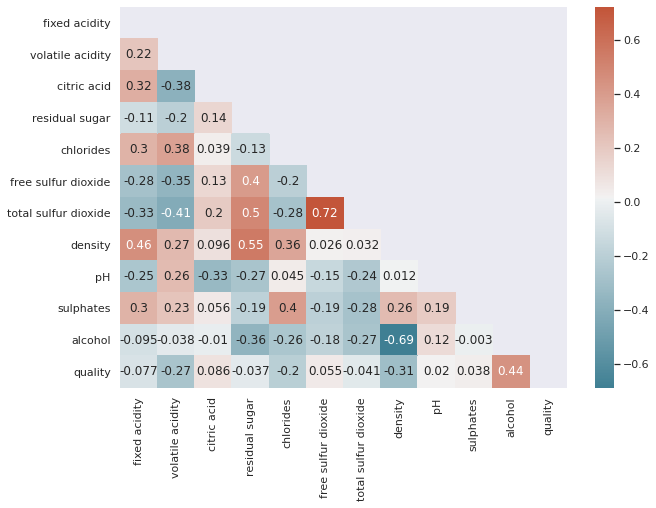

In [16]:
corr = wine.corr()
plt.figure(figsize=(10,7))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, cmap=sns.diverging_palette(220, 20, as_cmap=True), annot=True, mask=mask);

This correlation matrix shows high positive and negative correlations between some features, the highest being between total sulfur dioxide and free sulfur dioxide. Total sulfure dioxide is a sum of free sulfur dioxide in the wine and sulfur dioxide that bound to other chemicals, which explains their correlation. However, it does not necessarily mean one of the two features needs to be removed. We will double check with the variance inflation factor later on to decide whether some features need to be dropped for better model performance.

In [17]:
# Function to check the distribution of each features
def feat_plot(feature, hue):
    plt.figure(figsize=(9, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(x=feature, bins=15, hue=hue, multiple="stack")
    plt.title(f'{feature.name} histogram')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(y=feature, x=hue)
    plt.title(f'{feature.name} box plot')
    plt.show()

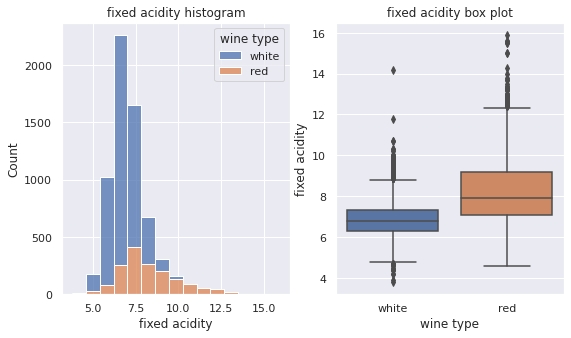

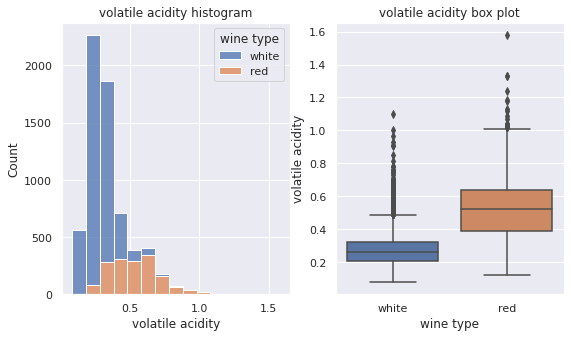

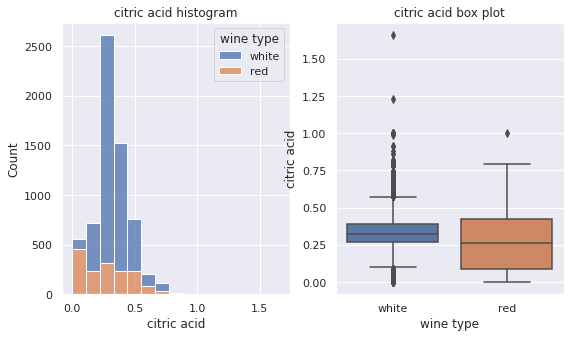

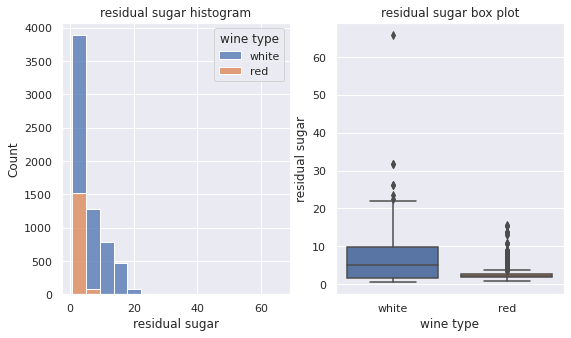

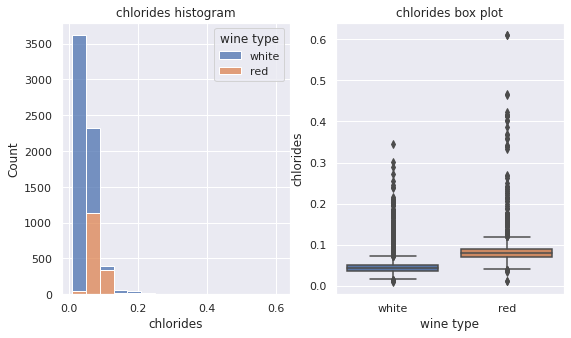

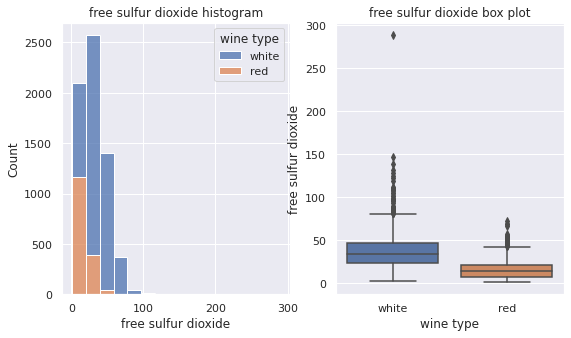

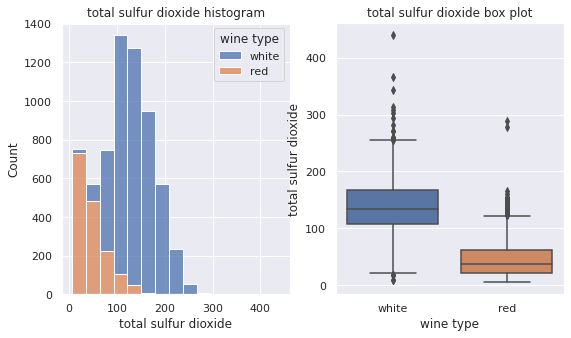

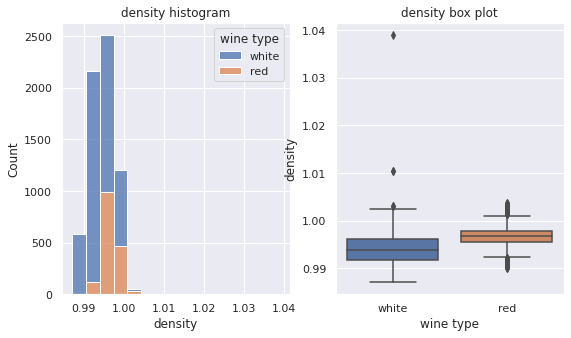

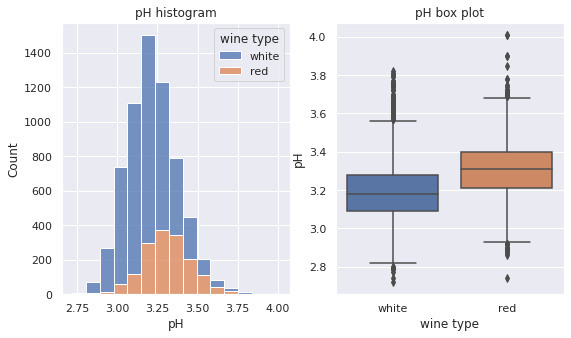

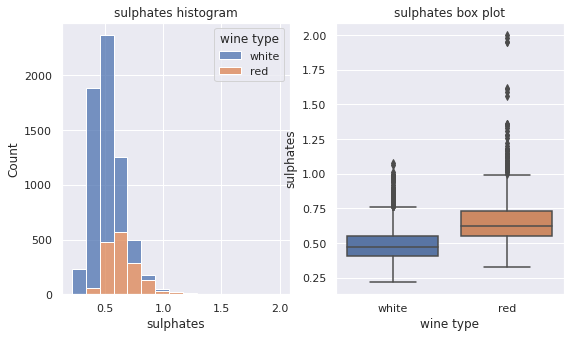

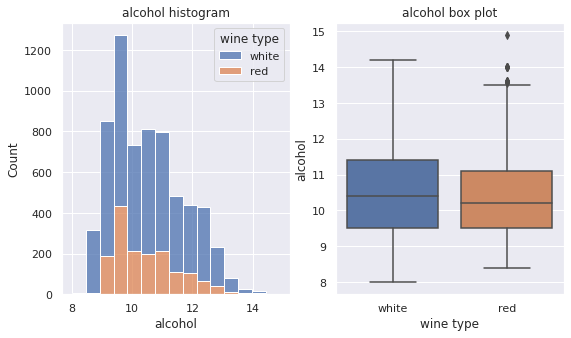

In [18]:
wine_plot = wine.iloc[:,0:-2]

for i in wine_plot.columns:
    feat_plot(wine_plot[i], wine['wine type'])

The boxplots and histograms confirm that there are outliers present for a majority of the features but it varies according to the type of wine. High outliers are dominant over low outliers, however we can observe low outliers for pH, hence both high and low outliers will be treated.

## Removing outliers

Outliers will be removed per type of wine to avoid an over generalised boundary that will result in dropping relevant instances for prediction. The boundaries are calculated using the interquartile range method, which can be used when the distribution is not Gaussian like. The 25th and 75th percentile are first calculated, and we substract the 25th percentile from the 75th percentile to obtain the interquartile range (iqr). To get the boundaries, we multiply the iqr by 1.5 to get the cut off value which is substracted or added to the percentiles. Any rows containing a value outside of the definied boundaries are dropped.

### Red wine

In [19]:
# Define which dataset will be used
data = red

# Create dictionaries where the keys are features and the values are 25th and 75th percentiles, the iqr and the cut off value
q25, q75, iqr, cut_off = {}, {}, {}, {}
for i in data.select_dtypes(include=['float64']).columns:
    q25[i] = np.percentile(data[i], 25)
    q75[i] = np.percentile(data[i], 75)
    iqr[i] = q75[i] - q25[i]
    cut_off[i] = iqr[i]*1.5

# Create a dictionary where the keys are features and the values the high boundary
dictionary_high = {}
for i in data.select_dtypes(include=['float64']).columns:
    dictionary_high[i] = q75[i] + cut_off[i]

# Create a dictionary where the keys are features and the values the low boundary
dictionary_low = {}
for i in data.select_dtypes(include=['float64']).columns:
    dictionary_low[i] = q25[i] - cut_off[i]
        
# Combine both dictionaries created above to have the high and low boundaries in one dictionary
keys = dictionary_high.keys()
values = zip(dictionary_high.values(), dictionary_low.values())
dictionary = dict(zip(keys, values))

# Create a dataframe from the dictionary
red_out = pd.DataFrame.from_dict(dictionary)

# Add columns to the dataframe to match and merge with the red dataset
red_out['wine type'] = 'white'
red_out['quality'] = int(red['quality'].mean())

red_out

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,wine type,quality
0,12.35,1.015,0.915,3.65,0.12,42.0,122.0,1.001187,3.685,1.00,13.5,white,5
1,3.95,0.015,-0.405,0.85,0.04,-14.0,-38.0,0.992248,2.925,0.28,7.1,white,5


In [20]:
# Merge the dataframe with outliers boundaries 
red_drop = pd.concat([red, red_out])
red_drop.reset_index(drop=True, inplace=True)

In [21]:
# Drop all rows where one feature's value is outside the predefined boundaries
for idx, val in enumerate(list(red_drop.iloc[-2,:-2].values)):
    red_drop.drop(red_drop.index[(red_drop.iloc[:, idx]) > float(red_drop.iloc[-2:-1, idx])], inplace=True)
    red_drop.drop(red_drop.index[(red_drop.iloc[:, idx]) < float(red_drop.iloc[-1:, idx])], inplace=True)

# Drop the two last rows whose values represented the boundaries
red_drop = red_drop.iloc[:-2, :]
red_drop.reset_index(drop=True, inplace=True)

### White wine

In [22]:
# Define which dataset will be used
data = white

# Create dictionaries where the keys are features and the values are 25th and 75th percentiles, the iqr and the cut off value
q25, q75, iqr, cut_off = {}, {}, {}, {}
for i in data.select_dtypes(include=['float64']).columns:
    q25[i] = np.percentile(data[i], 25)
    q75[i] = np.percentile(data[i], 75)
    iqr[i] = q75[i] - q25[i]
    cut_off[i] = iqr[i]*1.5

# Create a dictionary where the keys are features and the values the high boundary
dictionary_high = {}
for i in data.select_dtypes(include=['float64']).columns:
    dictionary_high[i] = q75[i] + cut_off[i]

# Create a dictionary where the keys are features and the values the low boundary
dictionary_low = {}
for i in data.select_dtypes(include=['float64']).columns:
    dictionary_low[i] = q25[i] - cut_off[i]
        
# Combine both dictionaries created above to have the high and low boundaries in one dictionary
keys = dictionary_high.keys()
values = zip(dictionary_high.values(), dictionary_low.values())
dictionary = dict(zip(keys, values))

# Create a dataframe from the dictionary
white_out = pd.DataFrame.from_dict(dictionary)

# Add columns to the dataframe to match and merge with the red dataset
white_out['wine type'] = 'white'
white_out['quality'] = int(white['quality'].mean())

white_out

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,wine type,quality
0,8.8,0.485,0.57,22.2,0.071,80.5,255.5,1.002666,3.565,0.76,14.25,white,5
1,4.8,0.045,0.09,-10.6,0.015,-11.5,19.5,0.985156,2.805,0.20,6.65,white,5


In [23]:
# Merge the dataframe with outliers boundaries 
white_drop = pd.concat([white, white_out])
white_drop.reset_index(drop=True, inplace=True)

In [24]:
# Drop all rows where one feature's value is outside the predefined boundaries
for idx, val in enumerate(list(white_drop.iloc[-2,:-2].values)):
    white_drop.drop(white_drop.index[(white_drop.iloc[:, idx]) > float(white_drop.iloc[-2:-1, idx])], inplace=True)
    white_drop.drop(white_drop.index[(white_drop.iloc[:, idx]) < float(white_drop.iloc[-1:, idx])], inplace=True)

# Drop the two last rows whose values represented the boundaries
white_drop = white_drop.iloc[:-2, :]
white_drop.reset_index(drop=True, inplace=True)

In [25]:
# Merge the red and white dataset
wine_new = pd.concat([white_drop, red_drop])
wine = wine_new.copy()
wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,wine type,quality
0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,white,6
1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,white,6
2,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,white,6
3,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,white,6
4,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,white,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1189,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,red,5
1190,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,red,6
1191,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,red,6
1192,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,red,5


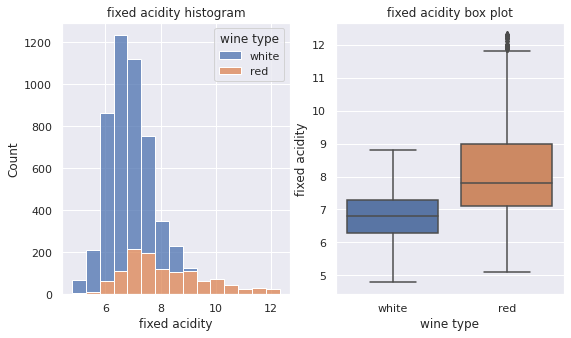

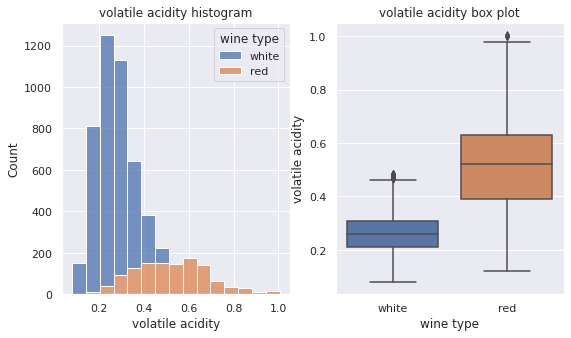

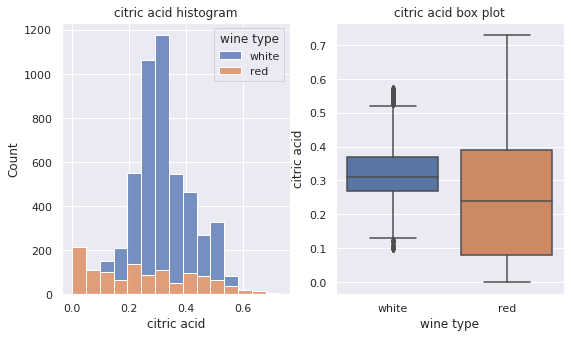

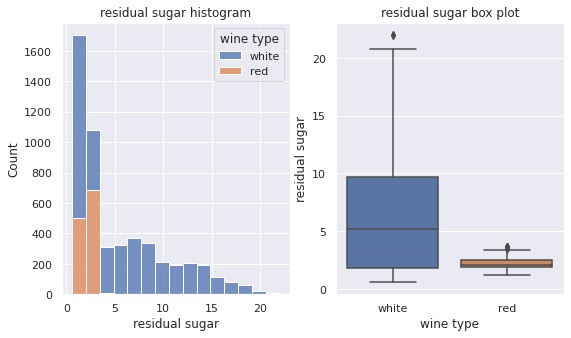

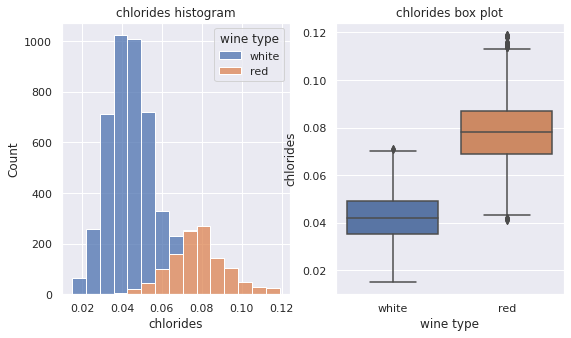

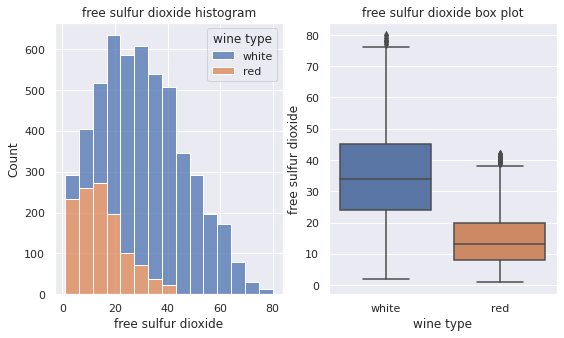

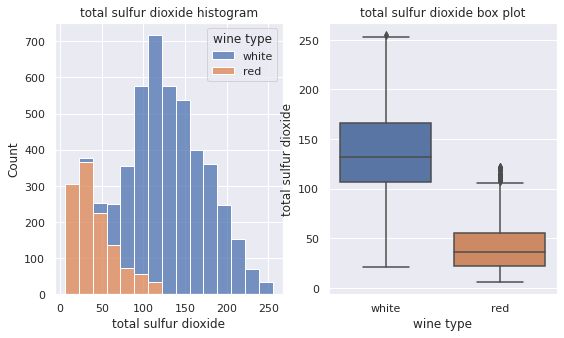

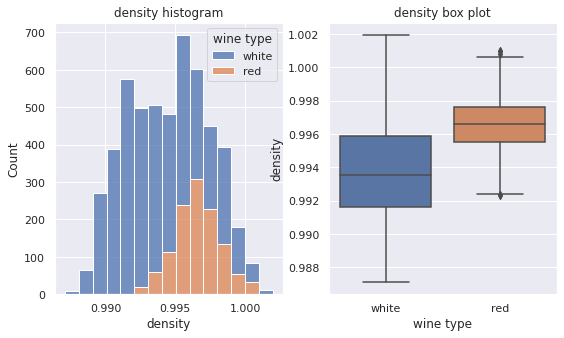

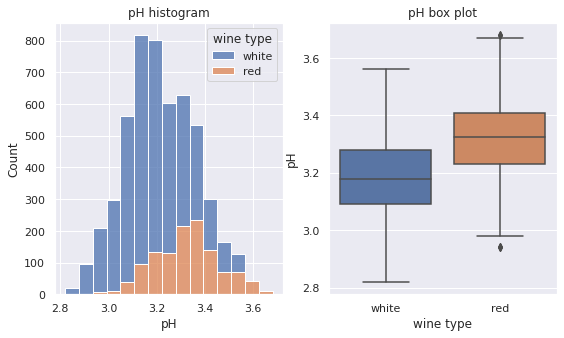

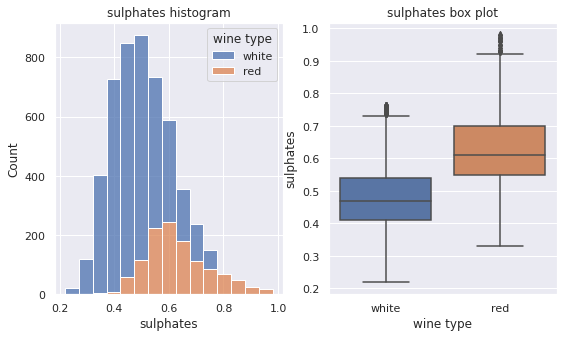

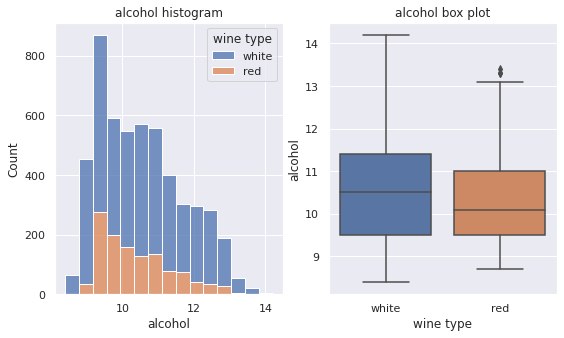

In [26]:
# Plot the graphs again to check if outliers have been removed
wine_plot = wine.iloc[:,0:-2]

for i in wine_plot.columns:
    feat_plot(wine_plot[i], wine['wine type'])

We can notice on the graphs above that the outliers have been removed. However, even if the data appears more normally distributed, we want to achieve better distribution for better performance when inputting the data into our models. To investigate this further, we plot below quantile-quantile plots (QQplot) and calculate the skewness and kurtosis to only treat the features that aren't normally distributed, rather than the whole dataset.

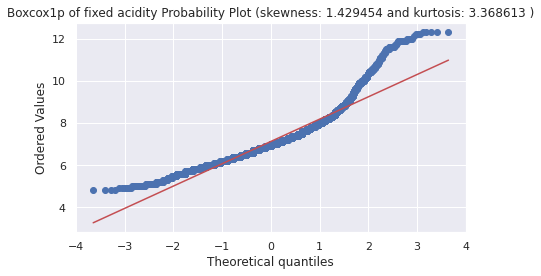

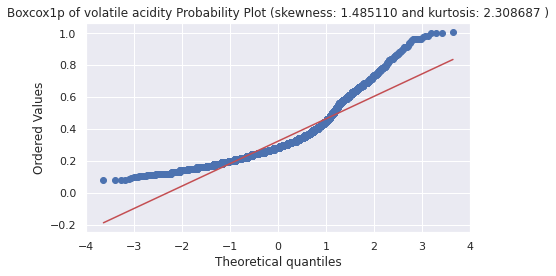

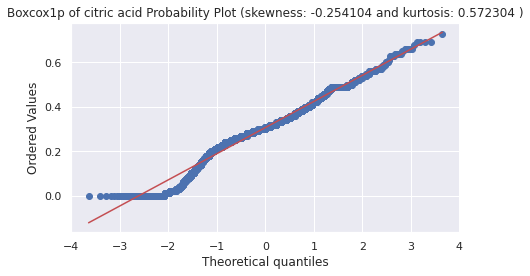

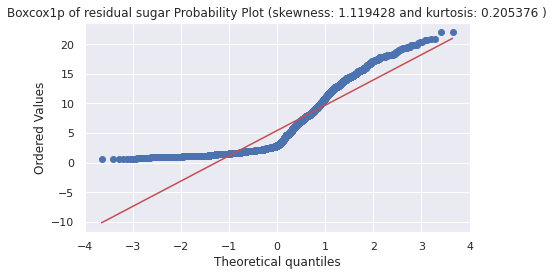

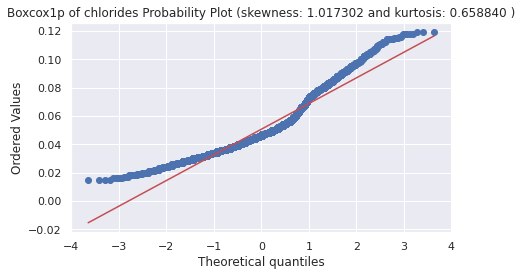

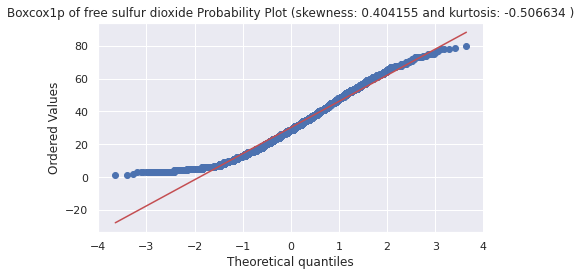

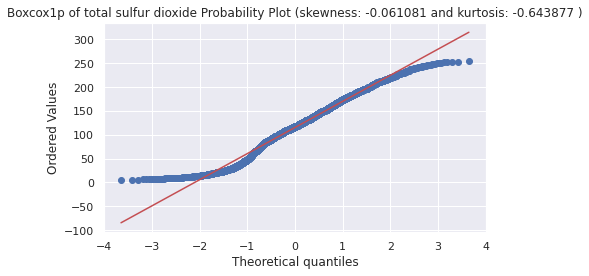

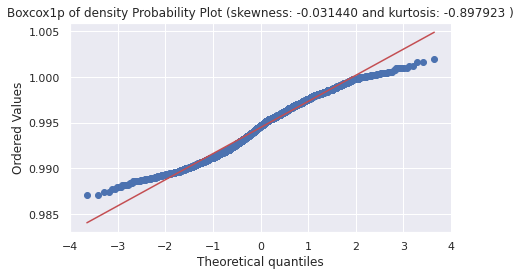

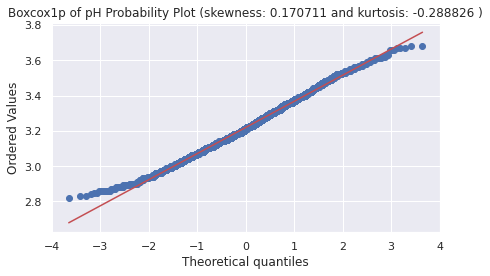

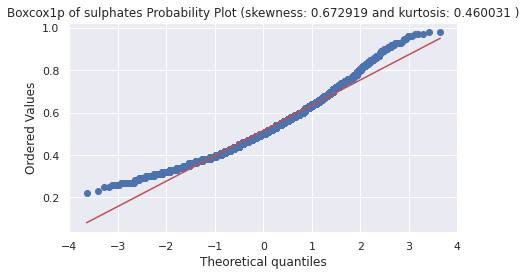

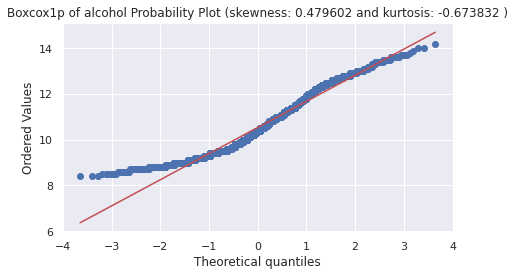

In [27]:
from scipy.stats import skew, norm, probplot, boxcox, f_oneway

def QQ_plot(data, measure):
    fig = plt.figure(figsize=(12,4))
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.\
                   format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()
    
wine_plot = wine.iloc[:,0:-2]
    
for i in wine_plot.columns:
    QQ_plot(wine_plot[i], ('Boxcox1p of {}'.format(i)))

The graphs and statistical measures confirm that half of the features are not normally distributed and have high skewness. Indeed, ideally, the skewness should be in the range of [-0.5, 0.5] and the kurtosis in the range of [-3, 3]. Fixed acidity, volatile acidity, residual sugar, chlorides and sulphates need to be transformed, which will be done after splitting, to achieve results closer to normal distribution.

# Encoding

Before splitting the data, we first create binary variables for the wine type feature where 1 = white, 0 = red to facilitate model training. During a first attempt of training models, the feature wine quality was kept as is, with 7 different values. However, the machine learning algorithms were achieving very low training scores of around 50%. Which can be explained by the variance of feature values within a quality set. Splitting the categorical values of wine quality into 2 bins, were low quality (0) includes wines labeled as 3, 4 and 5, and high quality (1) includes wines labeled as 6, 7, 8 and 9, achieved much better result. By allocating qualities in two bins, the dataset if more balanced and the features are more representative of each bin.

In [28]:
from sklearn.preprocessing import LabelEncoder

# Create binary variables for wine type
labelencoder = LabelEncoder()

y_type = labelencoder.fit_transform(wine['wine type'].values)
wine['wine type'] = y_type

In [29]:
# Create dictionary to associate different qualities to there designated bin and integrate it in the main dataset
quality_map = {3:'low', 4:'low', 5:'low', 6:'high', 7:'high', 8:'high', 9:'high'}
wine['quality'] = wine['quality'].map(quality_map)

# Create dictionary to transform the categorical bins into numerical values and integrate it in the main dataset
quality_map2 = {'low':0, 'high':1}
wine['quality'] = wine['quality'].map(quality_map2)

# Check the number of wines in each bin
wine['quality'].value_counts()

1    3457
0    1752
Name: quality, dtype: int64

# Data pre-processing

We will first pre-process the data on the data splitted for predicting the type of wine. Firstly, the features that we have previously observed as skewed will be loged; secondly, we will check the variance inflation factor. If some features appear to be multi-collinear, before removing them from the dataset, we will standardise the data and check the VIF again to keep as many features as possible.

## Splitting data for type of wine models

In [98]:
from sklearn.model_selection import train_test_split

# Define independent and dependent variables
X = wine.iloc[:, :-2]
y = wine.iloc[:, -2:-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

# Transform the dependent variables to a 1D array
y_train, y_test = np.ravel(y_train,order="c"), np.ravel(y_test,order="c")

### Log skewed features

In [99]:
from sklearn.preprocessing import PowerTransformer

# Function to log specific features merge it with our main dataset
def logarithmic(x, features):
    pt = PowerTransformer(method='yeo-johnson')
    x_log = x.copy()
    x_log = pt.fit_transform(x_log.loc[:, features])
    x.loc[:, skewed_feat] = x_log

In [100]:
# Create list of skewed features
skewed_feat = ['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides', 'sulphates']

# Log the skewed features
logarithmic(X_train, skewed_feat)
logarithmic(X_test, skewed_feat)

In [101]:
# Dataframe to check values of skewness and kurtosis for each feature
skew_kurt = pd.concat([pd.DataFrame(X_train.skew()), pd.DataFrame(X_train.kurt())], axis=1)
skew_kurt.set_axis(['skewness', 'kutosis'], axis=1, inplace=True)
skew_kurt

,skewness,kutosis
fixed acidity,-0.033889,0.564096
volatile acidity,0.096494,-0.445325
citric acid,-0.272607,0.561643
residual sugar,0.142601,-1.364740
chlorides,0.082977,-0.415401
free sulfur dioxide,0.409681,-0.503840
total sulfur dioxide,-0.052694,-0.624014
density,-0.038882,-0.898171
pH,0.166591,-0.331305
sulphates,0.018034,-0.330360


We can confirm that the data is now normally distributed.

### Check and treat multi-collinearity with variance inflation factor (VIF)

In [102]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
  
# Calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
  
print(vif_data)

                 feature         VIF
0          fixed acidity    1.716216
1       volatile acidity    1.681618
2            citric acid   10.948524
3         residual sugar    1.528565
4              chlorides    2.361544
5    free sulfur dioxide   10.247904
6   total sulfur dioxide   16.323665
7                density  834.184423
8                     pH  696.758502
9              sulphates    1.353337
10               alcohol  134.636570


We can see that half of the features have a VIF larger than 10, which means they are multicollinear and could affect how our models perform. We will standardize the dataset to get better VIF results.

### Standardization

StandardScaler() is recommened when the data is normally distributed, which is now the case for our dataset after pre-processing it.

In [103]:
from sklearn.preprocessing import StandardScaler

# Define standard scaler
scaler = StandardScaler()

# Standardize data
X_train, X_test = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns), pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

Checking the VIF again after standardising the data. The results are a lot better but density still has a value above 10 and will be dropped from the dataset.

In [104]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                          for i in range(len(X_train.columns))]
  
print(vif_data)

                 feature        VIF
0          fixed acidity   2.649496
1       volatile acidity   1.747398
2            citric acid   1.462800
3         residual sugar   4.514445
4              chlorides   2.747271
5    free sulfur dioxide   2.290637
6   total sulfur dioxide   3.197201
7                density  11.905605
8                     pH   1.883700
9              sulphates   1.467746
10               alcohol   4.855272


In [105]:
# Drop density feature which is multicollinear
X_train.drop('density', axis=1, inplace=True)
X_test.drop('density', axis=1, inplace=True)

# Model building for wine type

Since classifying red and white wine is an easy task thanks to distinctive feature values, only two models will be trained and tune in this section. The two models consist of a simple Logistic Regression and the more complex ensemble method of Random Forest to compare their performance on a straigthforward exercise.

In [106]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score, validation_curve
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, accuracy_score, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from yellowbrick.classifier import ROCAUC

import matplotlib.gridspec as gridspec
from pandas.plotting import scatter_matrix
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Since the dataset is uneven both in terms of wine type and quality, there are 1194 red wines against 4015 white wines and 1752 low quality wines against 3457 high quality wines, the most appropriate performance metric is the F1 score. Indeed, when data is imbalanced, accuracy does not reflect how well the model performs since it assigns equal cost to false positives and false negatives. However, F1 Score accounts for both and provides a more accurate representation of the model's performance in our case.

In [39]:
# Function to display cross validation results
def scores_disp(model, x, y):
    scores = cross_val_score(model, x, y, cv=10, scoring="accuracy")
    print("Scores:", scores*100)
    print("Mean:", scores.mean()*100)
    print("Standard deviation:", scores.std()*100)

In [40]:
# Function for creating basic scores
def model_result(model, X_train, y_train):
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=10)
    
    print("Accuracy : ", accuracy_score(y_train,y_train_pred)*100) 
    print("Recall : ", recall_score(y_train, y_train_pred, average='macro')*100)
    print("Precision : ", precision_score(y_train, y_train_pred, average='macro')*100)
    print("F1 Score : ", f1_score(y_train, y_train_pred, average='macro')*100)

In [41]:
# Function for creating confusion matrix
def confusion_table(X_train, y_train, model):
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=10)
    cf_matrix = confusion_matrix(y_train, y_train_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    ax.set_title('Confusion Matrix \n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    plt.show()

## Logistic Regression

In [42]:
LR = LogisticRegression(max_iter=1000)

LR.fit(X_train, y_train) 
print("Training Score: ", LR.score(X_train,y_train)*100)

LogisticRegression(max_iter=1000)

Training Score:  99.92800575953925


In [43]:
# Display cross validation scores
scores_disp(LR, X_train, y_train)

Scores: [ 99.76019185  99.76019185 100.          99.76019185 100.
  99.76019185 100.         100.          99.75961538 100.        ]
Mean: 99.88003827707065
Standard deviation: 0.11996183373408455


Accuracy :  99.88000959923207
Recall :  99.81117676601221
Precision :  99.84810954959671
F1 Score :  99.8296281510717


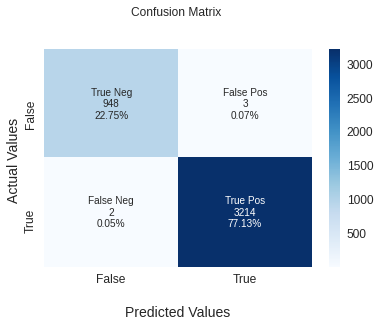

In [44]:
# Model performance metrics
model_result(LR, X_train, y_train)
confusion_table(X_train, y_train, LR)

### Grid Search

In [45]:
param = {'penalty':['l2'], 
         'C':[100, 10, 1.0, 0.1, 0.01], 
         'solver':['liblinear', 'sag', 'lbfgs', 'newton-cg'], 
         'max_iter':[1000,10000],
         'class_weight':['balanced', None]}

grid = GridSearchCV(estimator = LR, param_grid=param, cv=10, verbose=1, scoring='f1_macro')
grid_res = grid.fit(X_train, y_train)

print("The Best Parameters : ", grid_res.best_estimator_)
print("The Best Score      : ", grid_res.best_score_*100)

Fitting 10 folds for each of 80 candidates, totalling 800 fits
The Best Parameters :  LogisticRegression(C=10, class_weight='balanced', max_iter=1000,
                   solver='liblinear')
The Best Score      :  99.86438354619082


In [46]:
# Run logisitic regression again with the best parameters
LR_grid = LogisticRegression(C=10, class_weight='balanced', max_iter=1000,solver='liblinear')

LR_grid.fit(X_train, y_train) 
print("Training Score: ",LR_grid.score(X_train,y_train)*100)

LogisticRegression(C=10, class_weight='balanced', max_iter=1000,
                   solver='liblinear')

Training Score:  99.95200383969282


Accuracy :  99.90400767938566
Recall :  99.90078197341369
Precision :  99.82704537010495
F1 Score :  99.86385378412639


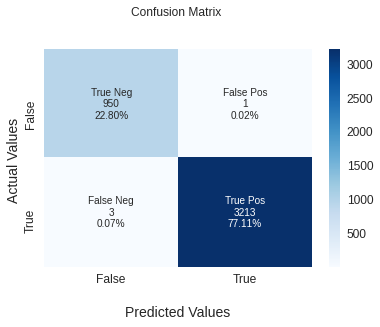

In [47]:
model_result(LR_grid, X_train, y_train)
confusion_table(X_train, y_train, LR_grid)

Since the classifying the type of wine is an easy task, a simple model like Logistic Regression performs extremely well with an accuracy score of 99.88 and an F1 Score of 99.82. Although there was not much room for improvement, the new parameters obtained via Grid Search have improved the models' perfomance with an F1 Score of 99.86. It has correctly classifed two extra wines as red despite wrongly classifying a white wine a red. The class weight parameter was added within the grid search to address the imbalance.

### Fit tuned Logistic Regression model on test set

In [ ]:
LR.fit(X_test, y_test)
print("Training Score: ", LR.score(X_test,y_test)*100)

In [ ]:
model_result(LR_grid, X_test, y_test)
confusion_table(X_test, y_test, LR_grid)

According to the performace metrics, the model performed almost as good on the test set as it did on the train set. We will next run a random forest model and compare it with Logistic Regression.

## RandomForest

In [107]:
RFC = RandomForestClassifier()

RFC.fit(X_train, y_train)
print("Training Score: ", RFC.score(X_train,y_train)*100)

RandomForestClassifier()

Training Score:  100.0


In [108]:
# Display cross validation scores
scores_disp(RFC, X_train, y_train)

Scores: [100.         100.         100.          99.76019185  99.76019185
 100.         100.         100.          99.75961538  99.75961538]
Mean: 99.90396144622761
Standard deviation: 0.1176228674487431


Accuracy :  99.88000959923207
Recall :  99.84820573787215
Precision :  99.81133277572305
F1 Score :  99.82975427826642


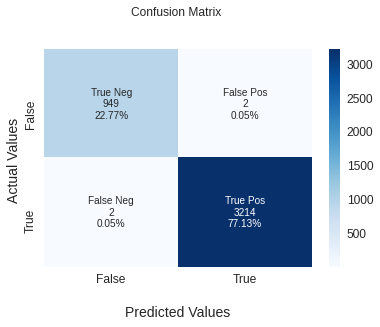

In [109]:
# Model performance metrics
model_result(RFC, X_train, y_train)
confusion_table(X_train, y_train, RFC)

### Grid search

In [114]:
param = {'criterion':['gini', 'entropy'], 
         'n_estimators':[70,80,90], 
         'max_depth':[5,10,15,20], 
         'max_features':[3,4,5], 
         'min_samples_split':[3,4], 
         'min_samples_leaf':[1,2,3], 
         'class_weight':['balanced', None]}

grid = GridSearchCV(estimator = RFC, param_grid=param, cv=5, verbose=1, n_jobs=-1)
grid_res = grid.fit(X_train, y_train)

print("The Best Parameters : ", grid_res.best_estimator_)
print("The Best Score      : ", grid_res.best_score_*100)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
The Best Parameters :  RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=3,
                       min_samples_split=4, n_estimators=80)
The Best Score      :  99.95198079231692


In [117]:
# Run random forest again with the best parameters
RFC_grid = RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=3, min_samples_split=4, n_estimators=80)

RFC_grid.fit(X_train, y_train)
print("Training Score: ", RFC_grid.score(X_train,y_train)*100)

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=3,
                       min_samples_split=4, n_estimators=80)

Training Score:  99.97600191984641


Accuracy :  99.95200383969282
Recall :  99.93187650077687
Precision :  99.93187650077687
F1 Score :  99.93187650077687


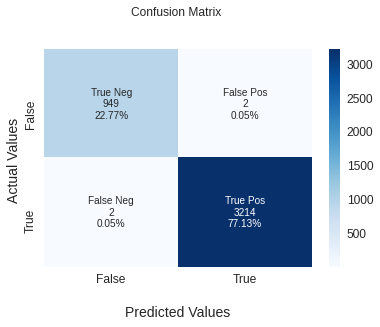

In [118]:
model_result(RFC_grid, X_train, y_train)
confusion_table(X_train, y_train, RFC_grid)

The Grid Search has been run multiple times with different numbers of parameters and hyperparameters until a similar of higher F1 Score is achieved. The F1 Score has increased by 0.11 points and we can observe from the confusion matrix that the number of false positives and false negatives reduced by one each. Again, the class weight parameter was added within the grid search to address the imbalance.

### Fit model on test set 

In [56]:
RFC_grid.fit(X_test, y_test)
print("Training Score: ", RFC_grid.score(X_test,y_test)*100)

RandomForestClassifier(class_weight='balanced', max_depth=15, max_features=3,
                       min_samples_split=3, n_estimators=80)

Training Score:  100.0


Accuracy :  99.32821497120922
Recall :  98.84603697008092
Precision :  99.27161263507898
F1 Score :  99.05674895219474


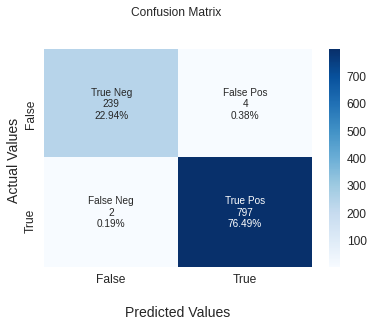

In [57]:
model_result(RFC_grid, X_test, y_test)
confusion_table(X_test, y_test, RFC_grid)

When looking at the F1 Score on the train set, Random Forest performs better than Logistic Regression. However, when fitted on the test set, the latter has a higher F1 Score and less false positives. Since the performance of both models is already very high without tuning it, the outcomes of tuning vary a lot and in some instances have been worse than with the basic model. Since all scores are already high on both the train and test set, one could argue that performing Grid Search could be omitted to save time and computational power.

# Model building for wine quality

After training models to predict the type of wine, we will look at models to predict wether the wine is low or high quality. The data needs to be split again as the dependent variable has changed, the same data pre-processing methods are applied and we will train 9 models.

In [120]:
# Independent and dependent variables
X = wine.iloc[:, :-1]
y = wine.iloc[:, -1:] # Quality

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

# Convert dependent variables to 1D arrays
y_train, y_test = np.ravel(y_train,order="c"), np.ravel(y_test,order="c")

In [121]:
# Create list of skewed features
skewed_feat = ['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides', 'sulphates']

# Log the skewed features
logarithmic(X_train, skewed_feat)
logarithmic(X_test, skewed_feat)

In [122]:
# Define standard scaler
scaler = StandardScaler()

# Standardize data
X_train, X_test = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns), pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

In [123]:
# Drop density feature which is multicollinear
X_train.drop('density', axis=1, inplace=True)
X_test.drop('density', axis=1, inplace=True)

## Model Training

In [62]:
# Function to get training score of all selected models
def train_models(model, x, y):
    model.fit(x, y)
    print(f'{model} Training Score :', model.score(x,y)*100)
    
models = {'LR':LogisticRegression(), 'GNB':GaussianNB(), 'KNN':KNeighborsClassifier(), 'DTC':DecisionTreeClassifier(), 
          'RFC':RandomForestClassifier(), 'SGCD':SGDClassifier(), 'GBC':GradientBoostingClassifier(), 'ABC':AdaBoostClassifier(),
          'XGBC':XGBClassifier(use_label_encoder=False, eval_metric = 'mlogloss')}

for i,j in models.items():
    i=j
    train_models(i, X_train, y_train)

LogisticRegression() Training Score : 75.35397168226542
GaussianNB() Training Score : 70.29037676985841
KNeighborsClassifier() Training Score : 84.13726901847852
DecisionTreeClassifier() Training Score : 100.0
RandomForestClassifier() Training Score : 100.0
SGDClassifier() Training Score : 73.2181425485961
GradientBoostingClassifier() Training Score : 82.0254379649628
AdaBoostClassifier() Training Score : 78.16174706023517
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=

From those results we can see that the ensemble method Random Forest and Decision Tree have the highest training score with a 100%, followed by Extreme Gradient Boosting with 98.87%. Such high score are very likely a sign of models overfitting the data. To get more accurate scores of how the models perform, we will run a 10 fold cross validation for each model to compare with their initial training score and analyse their performance metrics.

In [63]:
# Function to get cross validation scores, the accucary, recall, precision and F1 scores
def disp_scores(model, x, y):
    scores = cross_val_score(model, x, y, cv=10, scoring="accuracy")
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=10)    
    print(model, '\n')
    print("Cross Validation Score :", scores.mean()*100)
    print("Accuracy : ", accuracy_score(y_train,y_train_pred)*100)
    print("Recall : ", recall_score(y_train, y_train_pred, average='macro')*100)
    print("Precision : ", precision_score(y_train, y_train_pred, average='macro')*100)
    print("F1 Score : ", f1_score(y_train, y_train_pred, average='macro')*100, '\n\n')

for i,j in models.items():
    i=j
    disp_scores(i, X_train, y_train)

LogisticRegression() 

Cross Validation Score : 75.32996679579414
Accuracy :  75.32997360211183
Recall :  69.61372360221849
Precision :  72.41371793487738
F1 Score :  70.52124365167845 


GaussianNB() 

Cross Validation Score : 70.00259407858329
Accuracy :  70.00239980801535
Recall :  64.55421261487592
Precision :  65.7272136797009
F1 Score :  64.9729453618968 


KNeighborsClassifier() 

Cross Validation Score : 75.85817884154216
Accuracy :  75.85793136549076
Recall :  70.96992787569393
Precision :  72.8886549622784
F1 Score :  71.68922072996392 


DecisionTreeClassifier() 

Cross Validation Score : 77.20156567054049
Accuracy :  77.24982001439885
Recall :  74.38716400169216
Precision :  74.3695180841628
F1 Score :  74.37831855307584 


RandomForestClassifier() 

Cross Validation Score : 82.79255441800404
Accuracy :  82.67338612910967
Recall :  78.77530125328633
Precision :  81.18718513455356
F1 Score :  79.74251235417123 


SGDClassifier() 

Cross Validation Score : 72.81025179856115
A

When using cross validation, we get a more accurate reflection of how the models perform on the train set. Random Forest and XGBoost are the two models with the best results, whereas Decision Tree who initally scored 100%, ends up scoring lower than Gradient Boosting. We will tune the hyperparameters of Random Forest to try and improve its F1 Score. 

## Random Forest

Check perfomance of Random Forest again.

In [64]:
RFC = RandomForestClassifier()

RFC.fit(X_train, y_train)
print('Training Score :', RFC.score(X_train, y_train)*100)

cross_val_score(RFC, X_train, y_train, cv=10).mean()*100

RandomForestClassifier()

Training Score : 100.0


82.5769576646375

### Model performance metrics



Accuracy :  82.74538036957043
Recall :  79.02863171445107
Precision :  81.16956060835756
F1 Score :  79.90767951222722


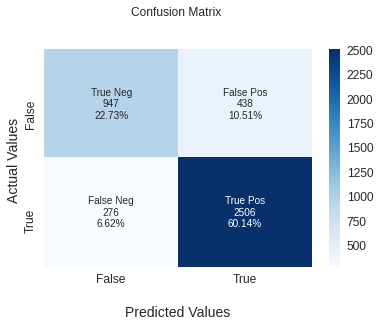

In [65]:
# Model performance metrics
model_result(RFC, X_train, y_train)
confusion_table(X_train, y_train, RFC)

In [66]:
# Compute the ROCAUC Score
roc_auc_score(y_test, RFC.predict_proba(X_test)[:, 1], average='macro')*100

87.97194469674035

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


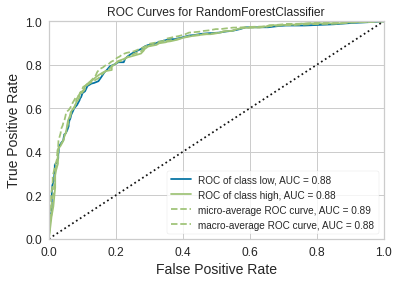

In [67]:
#Source: https://www.scikit-yb.org/en/latest/api/classifier/rocauc.html#multi-class-rocauc-curves

# Plot ROCAUC curves
visualizer = ROCAUC(RFC, classes=["low", "high"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show();                      # Finalize and render the figure

When comparing the Random Forest performance for predicting the wine type and wine quality, the model performs worse for quality prediction. Indeed, the task is more complicated as the features for the different qualities are not as discrete as for wine type. However, it still scores high performance metrics; we can see from the ROC AUC score that the default model will greatly fit the test set.

## RANDOM SEARCH

In [68]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 50, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2,3,4,5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,3,4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [1, 56, 111, 167, 222, 278, 333, 389, 444, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 6, 11, 17, 22, 28, 33, 39, 44, 50, None], 'min_samples_split': [2, 3, 4, 5], 'min_samples_leaf': [1, 2, 3, 4], 'bootstrap': [True, False]}


In [69]:
RFC_random = RandomizedSearchCV(estimator = RFC, param_distributions=random_grid, n_iter=100, 
                                cv = 5, verbose=1, n_jobs=-1, scoring='f1_macro')
# Fit the random search model
RFC_random.fit(X_train, y_train)
print("The Best Parameters : ", RFC_random.best_estimator_)
print("The Best Score      : ", RFC_random.best_score_*100)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [1, 6, 11, 17, 22, 28, 33,
                                                      39, 44, 50, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 3, 4, 5],
                                        'n_estimators': [1, 56, 111, 167, 222,
                                                         278, 333, 389, 444,
                                                         500]},
                   scoring='f1_macro', verbose=1)

The Best Parameters :  RandomForestClassifier(bootstrap=False, max_depth=17, max_features='sqrt',
                       min_samples_leaf=3, min_samples_split=5,
                       n_estimators=56)
The Best Score      :  79.20162350435474


In [124]:
# Run random forest again with the best parameters
RFC_random = RandomForestClassifier(bootstrap=False, max_depth=17, max_features='sqrt', min_samples_leaf=3, min_samples_split=5,
                                    n_estimators=56)

RFC_random.fit(X_train, y_train)
print('Training Score :', RFC_random.score(X_train, y_train)*100)

cross_val_score(RFC_random, X_train, y_train, cv=10).mean()*100

RandomForestClassifier(bootstrap=False, max_depth=17, max_features='sqrt',
                       min_samples_leaf=3, min_samples_split=5,
                       n_estimators=56)

Training Score : 99.44804415646749


82.28889964951115

Accuracy :  82.14542836573074
Recall :  78.25300344919765
Precision :  80.49997058172538
F1 Score :  79.16074251728848


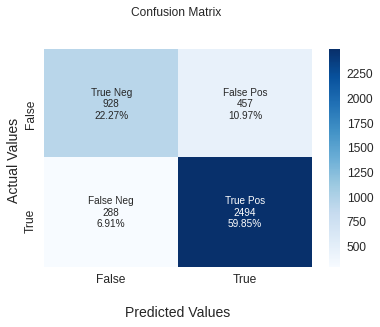

In [125]:
model_result(RFC_random, X_train, y_train)
confusion_table(X_train, y_train, RFC_random)

## Grid Search

### Validation curve

To choose hyperparameters for the Random Forest Grid Search, we plot validation curves, which show the sensitivity to changes in a model's scoring metric to changes in parameters. Graphs have been plotted for 5 different parameters we want to tune: n_estimators, max_depth, max_features, min_samples_split, min_samples_leaf. We can observe from the graphs above that changes in Random Forest's hyperparameters do not drastically change the performance of F1 Score, for all parameters the score stays somewhere between 0.70 and 0.80. Hence, through a trial and error method, the best hyperparameters to achieve a high F1 Score have been selected and ran through the Grid Search to reach better performance.

In [72]:
# Function to plot validation curve for each features we want to tune
def val_curve(param_range, model, x, y, param_name):
    
# Calculate accuracy on training and test set using range of parameter values
    train_scores, test_scores = validation_curve(model, x, y, param_name=param_name, 
                                                 param_range=param_range, cv=3, scoring="f1_macro", 
                                                 n_jobs=-1)
    
# Calculate mean and standard deviation for train set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
    plt.plot(param_range, train_mean, label="Training score", color="black")
    plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
    plt.title("Random Forest Validation Curve")
    plt.xlabel(param_name)
    plt.ylabel("F1 Score")
    plt.tight_layout()
    plt.legend(loc="best")
    plt.show();

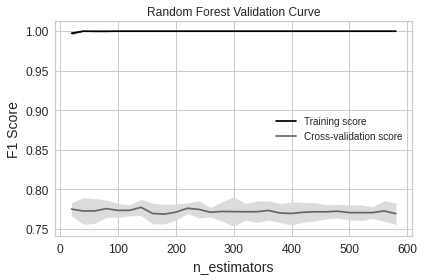

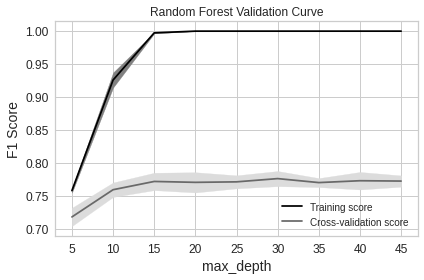

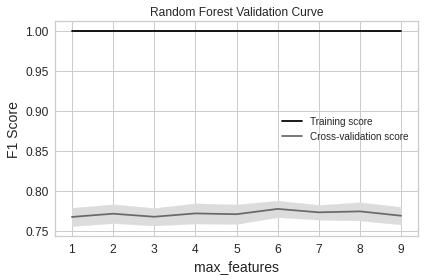

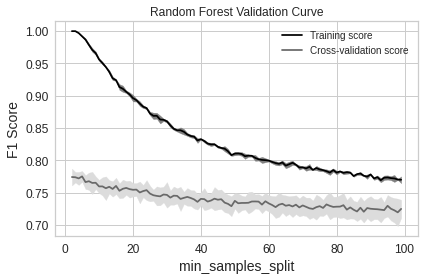

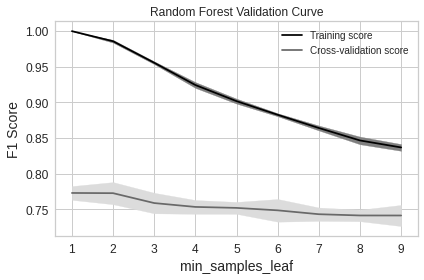

In [73]:
param_name_range = {'n_estimators':np.arange(0, 600, 20), 
                    'max_depth':np.arange(0, 50, 5), 
                    'max_features':np.arange(1, 10, 1), 
                    'min_samples_split':np.arange(1, 100, 1), 
                    'min_samples_leaf':np.arange(0, 10, 1)}

for i in param_name_range:
    val_curve(param_name_range[i], RFC, X_train, y_train, i)

In [74]:
# Grid Search
param = {'criterion':['gini', 'entropy'], 
         'n_estimators':[180, 220, 260], 
         'max_depth':[25,30], 
         'max_features':[2,5,8], 
         'min_samples_split':[2,3], 
         'min_samples_leaf':[1,2,3], 
         'class_weight':['balanced', None]}

grid = GridSearchCV(estimator = RFC, param_grid=param, cv=5, verbose=1, n_jobs=-1, scoring='f1_macro')
grid_res = grid.fit(X_train, y_train)

print("The Best Parameters : ", grid_res.best_estimator_)
print("The Best Score      : ", grid_res.best_score_*100)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
The Best Parameters :  RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=30, max_features=8, min_samples_leaf=2,
                       min_samples_split=3, n_estimators=220)
The Best Score      :  79.64995176987256


In [126]:
# Run random forest again with the best parameters
RFC_grid = RandomForestClassifier(class_weight='balanced', criterion='entropy', max_depth=30, max_features=8, min_samples_leaf=2,
                                  min_samples_split=3, n_estimators=220)

RFC_grid.fit(X_train, y_train)
print('Training Score :', RFC_grid.score(X_train, y_train)*100)

cross_val_score(RFC_grid, X_train, y_train, cv=10).mean()*100

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=30, max_features=8, min_samples_leaf=2,
                       min_samples_split=3, n_estimators=220)

Training Score : 99.97600191984641


82.60024672569637

Accuracy :  82.6013918886489
Recall :  79.15646484491587
Precision :  80.83848854981947
F1 Score :  79.87390089477975


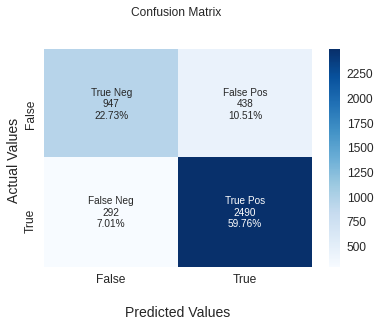

In [127]:
model_result(RFC_grid, X_train, y_train)
confusion_table(X_train, y_train, RFC_grid)

We can notice from both the Grid and Randomized Search that the F1 Score did not improve but stayed very close to the one computed with the default Random Forest model. However, we can notice that Recall increased for the model tuned with Grid Search.

### Fit on test set

RandomForestClassifier()

Training Score:  80.13435700575816
Accuracy :  78.1190019193858
Recall :  74.71874053890403
Precision :  76.2780817508851
F1 Score :  75.33635638827985


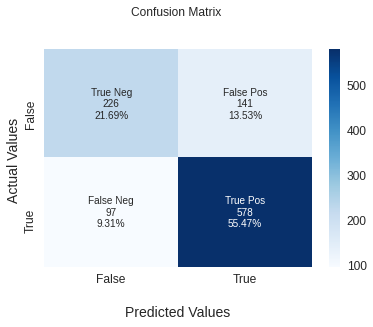

In [129]:
RFC.fit(X_test, y_test)
print("Training Score: ", RFC_grid.score(X_test,y_test)*100)

model_result(RFC, X_test, y_test)
confusion_table(X_test, y_test, RFC)

RandomForestClassifier(bootstrap=False, max_depth=17, max_features='sqrt',
                       min_samples_leaf=3, min_samples_split=5,
                       n_estimators=56)

Training Score:  99.23224568138195
Accuracy :  77.63915547024952
Recall :  74.28620446059138
Precision :  75.68960511033683
F1 Score :  74.85008105826354


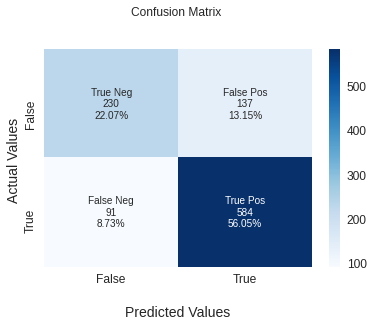

In [130]:
RFC_random.fit(X_test, y_test)
print("Training Score: ", RFC_random.score(X_test,y_test)*100)

model_result(RFC_random, X_test, y_test)
confusion_table(X_test, y_test, RFC_random)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=30, max_features=8, min_samples_leaf=2,
                       min_samples_split=3, n_estimators=220)

Training Score:  99.80806142034548
Accuracy :  78.02303262955854
Recall :  75.2663235442527
Precision :  75.9912132084247
F1 Score :  75.58952577074913


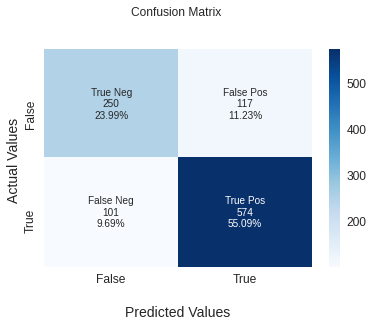

In [131]:
RFC_grid.fit(X_test, y_test)
print("Training Score: ", RFC_grid.score(X_test,y_test)*100)

model_result(RFC_grid, X_test, y_test)
confusion_table(X_test, y_test, RFC_grid)

Although the default model scored the highest F1 Score on the train set, we can see here that the model tuned with Grid Search performs 0.25 points better on the test, and almost 1 point better than the model tuned with Randomized Search. We could conclude that there is little margin for improvement. 

# Conclusions

Considering the results obtained from our models for both predicting tasks, we can confirm the data is more adapted to accurately predict the type of wine. Indeed, even though it has also performed well to predict the wine quality, it has only done so because the qualities were merged into two bins. It is a much harder task to predict each of the 7 qualities and achieve a satisfactory performance. Additionally, the Grid and Randomized Search failed to significantly improve the accuracy and F1 Score, which showed the limitations of the data.

# Limitations

With additional computational power and time, it would have been interesting to tune hyperparameters for XGBoost since it was a close competitor of Random Forest for wine quality prediction. Furthermore, additional data, especially for the lowest or highest quality wines might have allowed to either create more bins or accurately predict every quality. With only 5 wines classified a quality 9, it was not possible for the models to pick up any trends and learn from them.